In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
## dataframes inladen
test_df = pd.read_csv('test_c.csv')
train_df = pd.read_csv('train_c.csv')
display(test_df.head())
display(train_df.head())

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1,1,85,66,29,0,26.6,0.351,31
1,4,0,137,40,35,168,43.1,2.288,33
2,13,1,189,60,23,846,30.1,0.398,59
3,14,5,166,72,19,175,25.8,0.587,51
4,20,3,126,88,41,235,39.3,0.704,27


,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668,6,98,58,33,190,34.0,0.430,43,0
1,324,2,112,75,32,0,35.7,0.148,21,0
2,624,2,108,64,0,0,30.8,0.158,21,0
3,690,8,107,80,0,0,24.6,0.856,34,0
4,473,7,136,90,0,0,29.9,0.210,50,0


In [2]:
def get_clf_stats(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)   
     
    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print 
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion


## checken of data geschikt is voor ML

In [3]:
display(test_df.info())
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      154 non-null    int64  
 1   Pregnancies               154 non-null    int64  
 2   Glucose                   154 non-null    int64  
 3   BloodPressure             154 non-null    int64  
 4   SkinThickness             154 non-null    int64  
 5   Insulin                   154 non-null    int64  
 6   BMI                       154 non-null    float64
 7   DiabetesPedigreeFunction  154 non-null    float64
 8   Age                       154 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 11.0 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p_id                      614 non-null    int64  
 1   Pregnancies               614 non-null    int64  
 2   Glucose                   614 non-null    int64  
 3   BloodPressure             614 non-null    int64  
 4   SkinThickness             614 non-null    int64  
 5   Insulin                   614 non-null    int64  
 6   BMI                       614 non-null    float64
 7   DiabetesPedigreeFunction  614 non-null    float64
 8   Age                       614 non-null    int64  
 9   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 48.1 KB


None

In [4]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

train_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,385.542345,3.809446,120.465798,68.903909,20.456026,81.250814,31.929642,0.468096,33.265472,0.342020
std,222.135103,3.375544,31.959619,19.933385,16.063105,116.947384,8.136791,0.329203,11.851427,0.474773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,194.250000,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.238000,24.000000,0.000000
50%,380.500000,3.000000,115.000000,72.000000,23.000000,27.000000,32.150000,0.365500,29.000000,0.000000
75%,583.750000,6.000000,140.000000,80.000000,32.000000,130.000000,36.500000,0.628500,41.000000,1.000000
max,767.000000,15.000000,197.000000,114.000000,99.000000,744.000000,67.100000,2.420000,72.000000,1.000000


## outliers vinden en corrigeren

In [5]:
feature_names = [cname for cname in train_df.loc[:,:'Age'].columns]

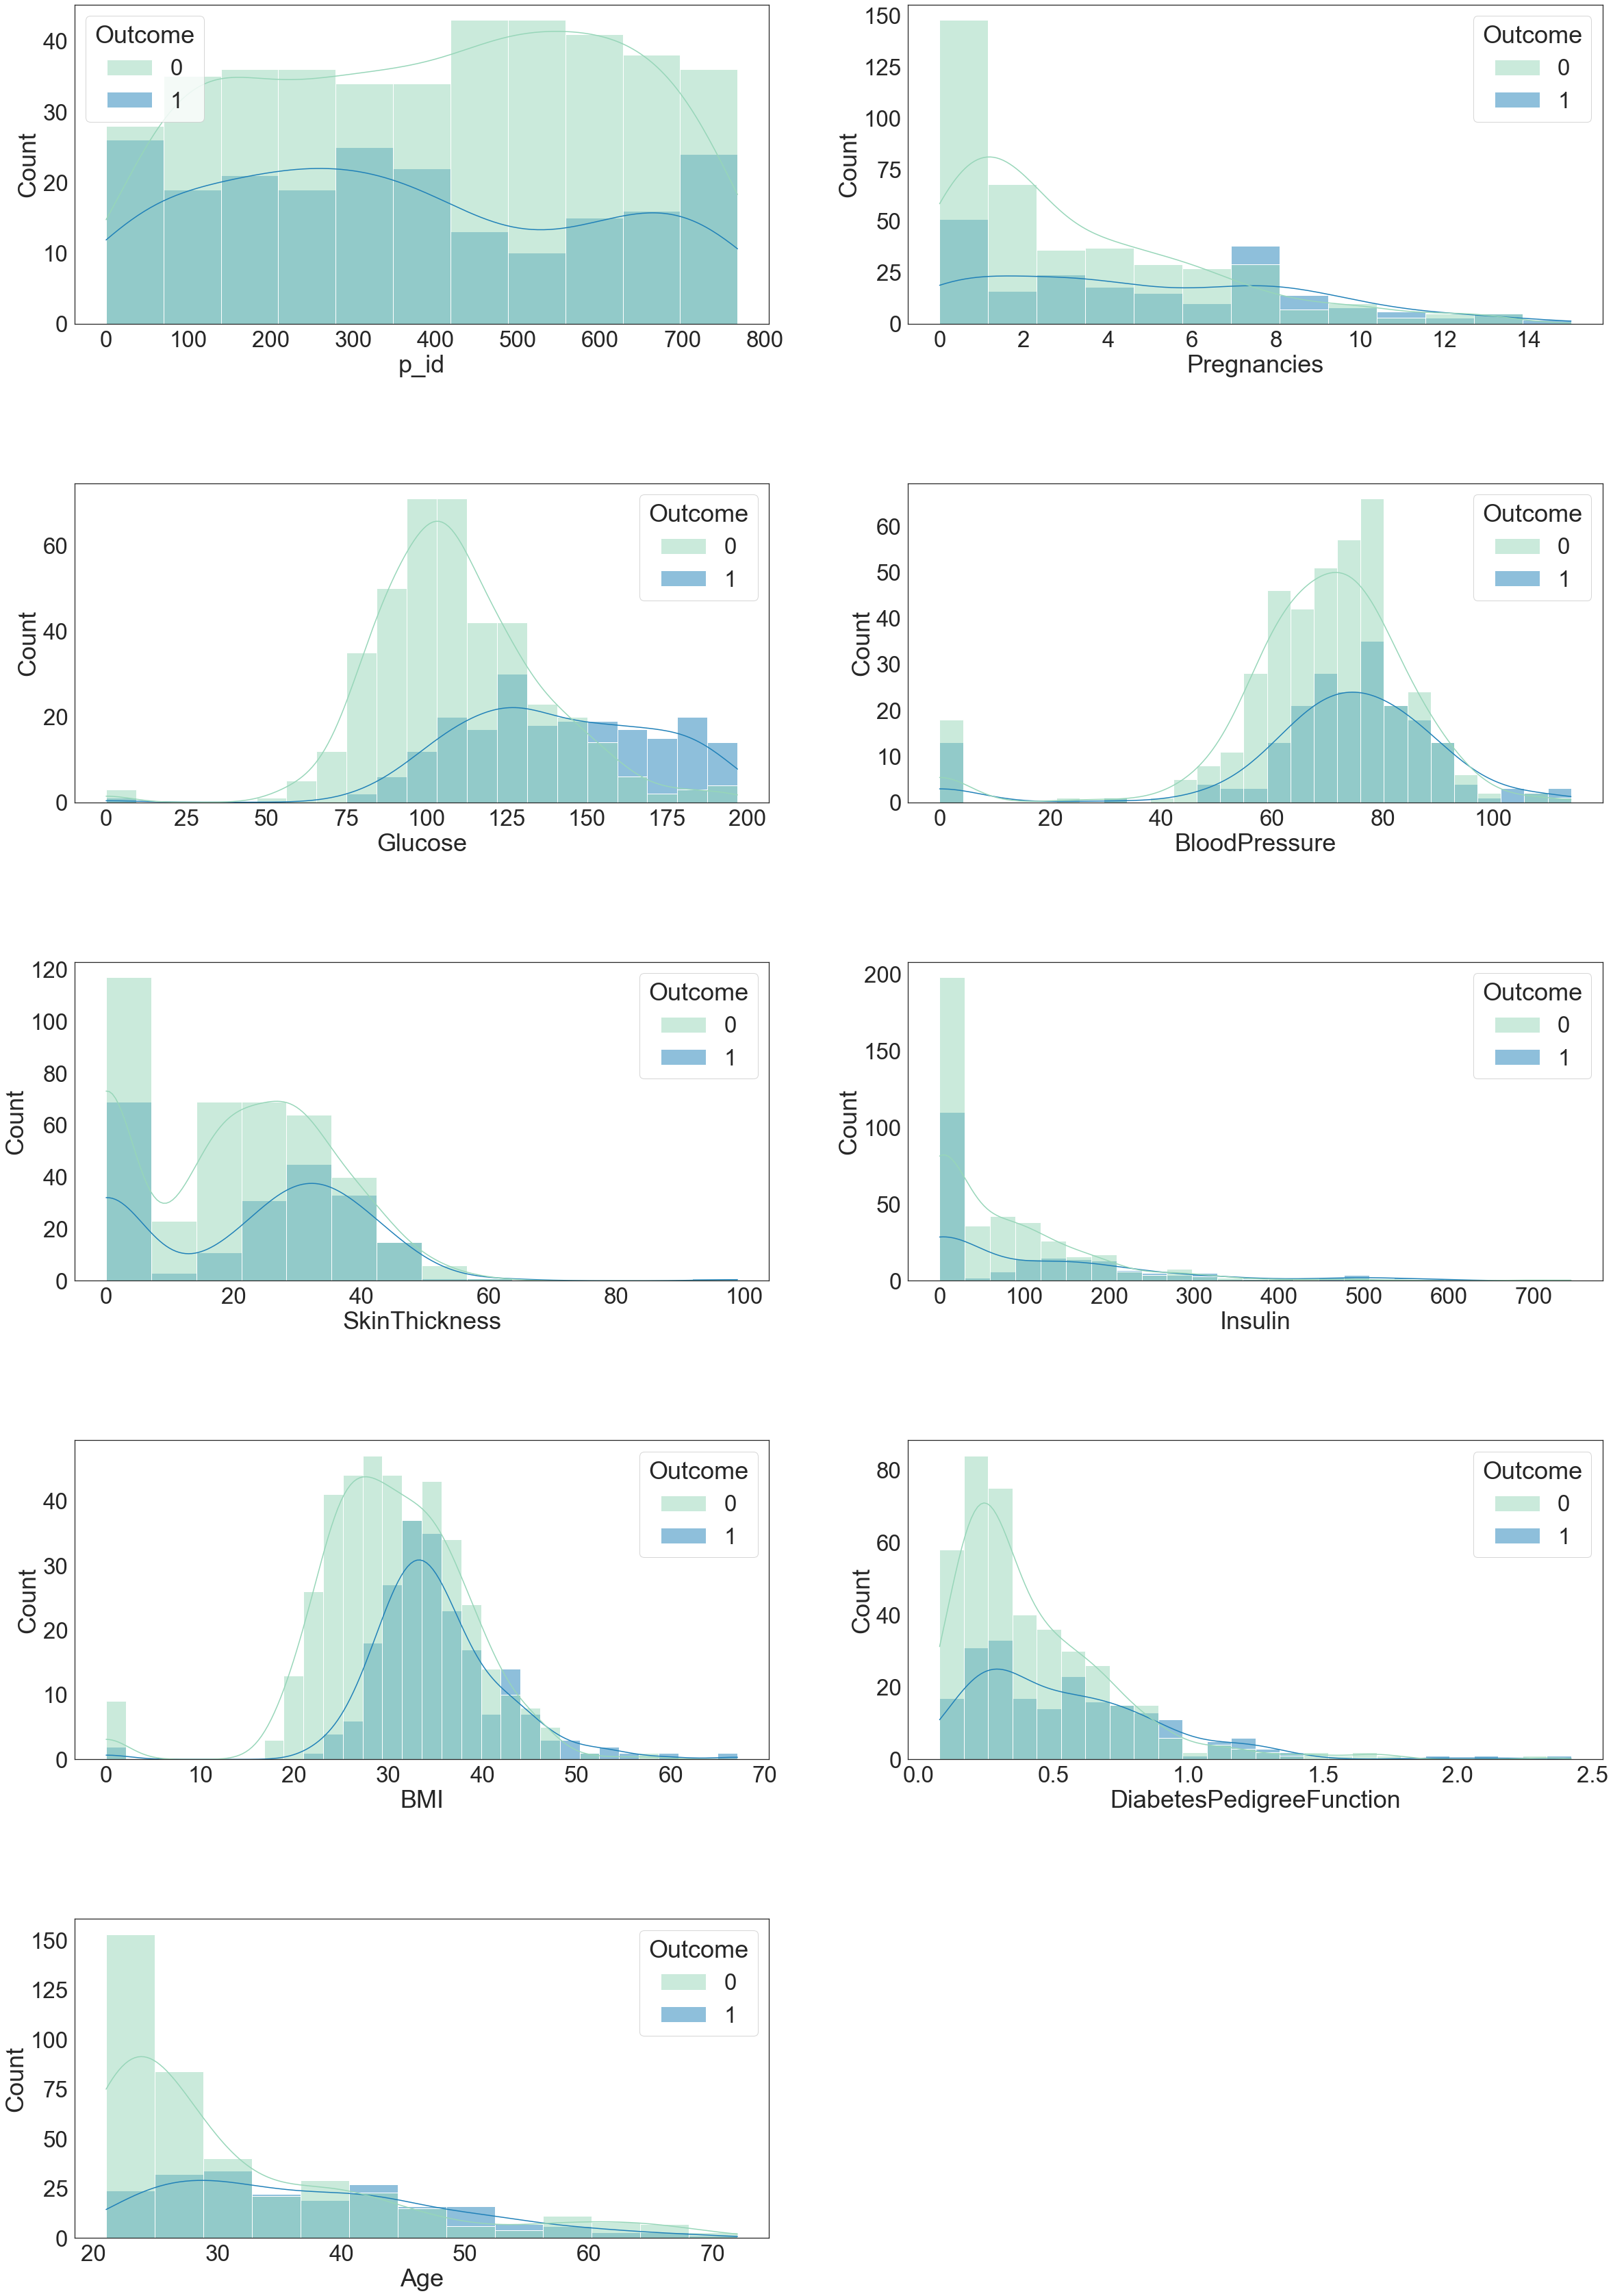

In [6]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=train_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

In [7]:
zero_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = train_df['Glucose'].count()

for feature in zero_features:
    zero_count = train_df[train_df[feature]==0][feature].count()
    print('{0} aantal 0 van {1}, percent = {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Pregnancies aantal 0 van 93, percent = 15.15 %
Glucose aantal 0 van 4, percent = 0.65 %
BloodPressure aantal 0 van 31, percent = 5.05 %
SkinThickness aantal 0 van 184, percent = 29.97 %
Insulin aantal 0 van 300, percent = 48.86 %
BMI aantal 0 van 11, percent = 1.79 %


In [8]:
train_df.isnull().sum()

p_id                        0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
train_df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = train_df[['Glucose',
                                                                                 'BloodPressure','SkinThickness','Insulin','BMI']].replace(0, np.NaN)

In [10]:
train_df.isnull().sum()

p_id                          0
Pregnancies                   0
Glucose                       4
BloodPressure                31
SkinThickness               184
Insulin                     300
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<AxesSubplot:>

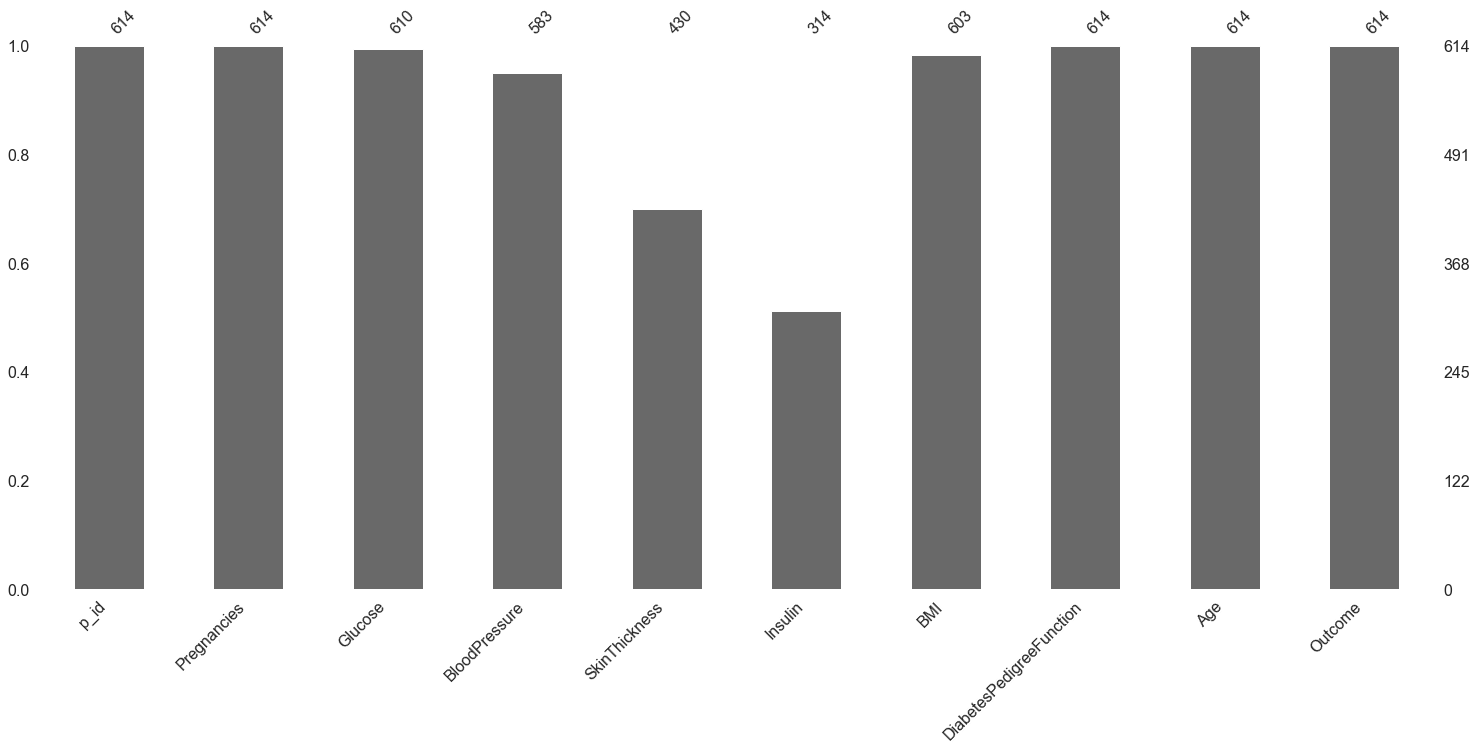

In [11]:
import missingno as msno
msno.bar(train_df)

In [12]:
def median_val(col):
    yo = train_df[train_df[col].notnull()]
    yo = yo[[col, 'Outcome']].groupby(['Outcome'])[[col]].median().reset_index()

    return yo

In [13]:
cols = train_df.columns
cols = list(cols.drop('Outcome'))
cols

['p_id',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [14]:
median_val('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [15]:
for col in cols:
    train_df.loc[(train_df['Outcome'] == 0) & (train_df[col].isnull()), col] = median_val(col)[col][0]
    train_df.loc[(train_df['Outcome'] == 1) & (train_df[col].isnull()), col] = median_val(col)[col][1]

In [16]:
train_df[(train_df['Outcome'] == 0 ) & (train_df["BloodPressure"].isnull())]

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [17]:
N_BMI = pd.Series(['Ondergewicht', 'Normaal', 'Overgewicht',
                   'Obese 1', 'Obese 2', 'Obese 3'], dtype = 'category')

train_df['N_BMI'] = N_BMI

train_df.loc[train_df['BMI'] < 18.5, 'N_BMI'] = N_BMI[0]

train_df.loc[(train_df['BMI'] > 18.5) & (train_df['BMI'] <= 24.5), 'N_BMI'] = N_BMI[1]
train_df.loc[(train_df['BMI'] > 24.9) & (train_df['BMI'] <= 29.9), 'N_BMI'] = N_BMI[2]
train_df.loc[(train_df['BMI'] > 29.9) & (train_df['BMI'] <= 34.9), 'N_BMI'] = N_BMI[3]
train_df.loc[(train_df['BMI'] > 34.9) & (train_df['BMI'] <= 39.9), 'N_BMI'] = N_BMI[4]
train_df.loc[train_df['BMI'] > 39.9, 'N_BMI'] = N_BMI[5]

In [18]:
train_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N_BMI
0,668.0,6,98.0,58.0,33.0,190.0,34.0,0.430,43,0,Obese 1
1,324.0,2,112.0,75.0,32.0,105.0,35.7,0.148,21,0,Obese 2
2,624.0,2,108.0,64.0,27.0,105.0,30.8,0.158,21,0,Obese 1
3,690.0,8,107.0,80.0,27.0,105.0,24.6,0.856,34,0,Obese 1
4,473.0,7,136.0,90.0,27.0,105.0,29.9,0.210,50,0,Overgewicht


In [19]:
def set_insulin(row):
    if row["Insulin"] >= 16 and row["Insulin"] <= 166:
        return "Normaal"
    else:
        return "Abnormaal"

In [20]:
train_df['insuline_nieuw'] = train_df.apply(set_insulin, axis = 1)
train_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N_BMI,insuline_nieuw
0,668.0,6,98.0,58.0,33.0,190.0,34.0,0.430,43,0,Obese 1,Abnormaal
1,324.0,2,112.0,75.0,32.0,105.0,35.7,0.148,21,0,Obese 2,Normaal
2,624.0,2,108.0,64.0,27.0,105.0,30.8,0.158,21,0,Obese 1,Normaal
3,690.0,8,107.0,80.0,27.0,105.0,24.6,0.856,34,0,Obese 1,Normaal
4,473.0,7,136.0,90.0,27.0,105.0,29.9,0.210,50,0,Overgewicht,Normaal


In [21]:
N_Glucose = pd.Series(["laag", "Normaal", "overgewicht", "hoog"], dtype = "category")
train_df["N_Glucose"] = N_Glucose

train_df.loc[train_df["Glucose"] <= 70, "N_Glucose"] = N_Glucose[0]
train_df.loc[(train_df["Glucose"] > 70) & (train_df["Glucose"] <= 99), "N_Glucose"] = N_Glucose[1]
train_df.loc[(train_df["Glucose"] > 99) & (train_df["Glucose"] <= 126), "N_Glucose"] = N_Glucose[2]
train_df.loc[train_df["Glucose"] > 126 ,"N_Glucose"] = N_Glucose[3]

In [22]:
train_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N_BMI,insuline_nieuw,N_Glucose
0,668.0,6,98.0,58.0,33.0,190.0,34.0,0.430,43,0,Obese 1,Abnormaal,Normaal
1,324.0,2,112.0,75.0,32.0,105.0,35.7,0.148,21,0,Obese 2,Normaal,overgewicht
2,624.0,2,108.0,64.0,27.0,105.0,30.8,0.158,21,0,Obese 1,Normaal,overgewicht
3,690.0,8,107.0,80.0,27.0,105.0,24.6,0.856,34,0,Obese 1,Normaal,overgewicht
4,473.0,7,136.0,90.0,27.0,105.0,29.9,0.210,50,0,Overgewicht,Normaal,hoog


In [23]:
df = pd.get_dummies(train_df, columns =["N_BMI","insuline_nieuw", "N_Glucose"], drop_first = True)

In [24]:
df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,N_BMI_Obese 1,N_BMI_Obese 2,N_BMI_Obese 3,N_BMI_Ondergewicht,N_BMI_Overgewicht,insuline_nieuw_Normaal,N_Glucose_hoog,N_Glucose_laag,N_Glucose_overgewicht
0,668.0,6,98.0,58.0,33.0,190.0,34.0,0.430,43,0,1,0,0,0,0,0,0,0,0
1,324.0,2,112.0,75.0,32.0,105.0,35.7,0.148,21,0,0,1,0,0,0,1,0,0,1
2,624.0,2,108.0,64.0,27.0,105.0,30.8,0.158,21,0,1,0,0,0,0,1,0,0,1
3,690.0,8,107.0,80.0,27.0,105.0,24.6,0.856,34,0,1,0,0,0,0,1,0,0,1
4,473.0,7,136.0,90.0,27.0,105.0,29.9,0.210,50,0,0,0,0,0,1,1,1,0,0


In [25]:
names_cat = list(df.columns[10:])

In [26]:
cat_df = df[names_cat]

In [27]:
X = df.drop(['p_id', 'Outcome', 'N_BMI_Obese 1', 'N_BMI_Obese 2', 'N_BMI_Obese 3', 'N_BMI_Ondergewicht',
             'N_BMI_Overgewicht', 'N_BMI_Overgewicht', 'insuline_nieuw_Normaal', 'N_Glucose_hoog',
            'N_Glucose_laag', 'N_Glucose_overgewicht'], axis = 1)
y = df.drop('p_id', axis = 1)['Outcome']

cols = X.columns
index = X.index

In [28]:
X = pd.concat([X, cat_df], axis = 1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI_Obese 1,N_BMI_Obese 2,N_BMI_Obese 3,N_BMI_Ondergewicht,N_BMI_Overgewicht,insuline_nieuw_Normaal,N_Glucose_hoog,N_Glucose_laag,N_Glucose_overgewicht
0,6,98.0,58.0,33.0,190.0,34.0,0.430,43,1,0,0,0,0,0,0,0,0
1,2,112.0,75.0,32.0,105.0,35.7,0.148,21,0,1,0,0,0,1,0,0,1
2,2,108.0,64.0,27.0,105.0,30.8,0.158,21,1,0,0,0,0,1,0,0,1
3,8,107.0,80.0,27.0,105.0,24.6,0.856,34,1,0,0,0,0,1,0,0,1
4,7,136.0,90.0,27.0,105.0,29.9,0.210,50,0,0,0,0,1,1,1,0,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1337)

In [68]:
## modellen maken
SEED = 1337
models = []
models.append(('LR', LogisticRegression(random_state = SEED)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(random_state = SEED)))
models.append(('RF', RandomForestClassifier(random_state = SEED)))
models.append(('SVM', SVC(gamma='auto', random_state = SEED)))
models.append(('XGB', GradientBoostingClassifier(random_state = SEED)))
models.append(('ADA', AdaBoostClassifier(random_state=SEED)))

#modellen evalueren
results = []
names = []

for name, model in models:
    Kfold = KFold(n_splits = 10, random_state = None)
    
    cv_results = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)
    


c:\Users\akers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\akers\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LR: 0.820487 (0.070633)
KNN: 0.843854 (0.048737)
DT: 0.827575 (0.072809)
RF: 0.869380 (0.026405)
SVM: 0.671318 (0.007105)
XGB: 0.857807 (0.039528)
ADA: 0.862569 (0.041955)


## Hypertuning RF

In [30]:
rf_params = {'n_estimators' :[100, 200, 500, 1000],
             'max_features' :[3, 5, 7],
             'min_samples_split': [2, 5, 10, 30],
             'max_depth': [3, 5, 8, None]}

In [31]:
rf_model = RandomForestClassifier(random_state = SEED)

In [69]:
gs_cv = GridSearchCV(rf_model,
                     rf_params,
                     cv = 10,
                     n_jobs = -1,
                     verbose = 2).fit(X_train, y_train)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [70]:
gs_cv.best_params_

{'max_depth': 3,
 'max_features': 7,
 'min_samples_split': 5,
 'n_estimators': 100}

In [77]:
rf_tuned = RandomForestClassifier(**gs_cv.best_params_).fit(X_train, y_train)
y_pred_rf = rf_tuned.predict(X_test)
accuracy_score(y_pred_rf, y_test)

0.8648648648648649

In [35]:
cross_val_score(rf_tuned, X, y, cv=10).mean()

0.8698043363299842

## hypertuning XGB

In [36]:
xgb_params = {'learning_rate': [0.01, 0.1, 0.2, 1],
              'min_samples_split': np.linspace(0.1, 0.5, 10),
              'max_depth': [3, 5, 8],
              'subsample': [0.5, 0.9, 1.0],
              'n_estimators': [100, 1000]}

In [37]:
xgb = GradientBoostingClassifier(random_state = SEED)

In [38]:
xgb_gs_cv = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2).fit(X, y)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


In [39]:
xgb_gs_cv.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'min_samples_split': 0.4111111111111111,
 'n_estimators': 100,
 'subsample': 0.9}

In [40]:
xgb_tuned = GradientBoostingClassifier(**xgb_gs_cv.best_params_).fit(X,y)

In [41]:
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

0.8714965626652564

## tuning logreg

In [42]:
logreg = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

In [43]:
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
grid_search = GridSearchCV(estimator = logreg, param_grid = grid, n_jobs = -1, cv=cv, scoring ='accuracy')
grid_result = grid_search.fit(X, y)

In [44]:
grid_result.best_params_

{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

In [45]:
logreg_tuned = LogisticRegression(**grid_result.best_params_).fit(X,y)

In [46]:
cross_val_score(logreg_tuned, X, y, cv = 10).mean()

0.8322845055526177

In [78]:
test_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI,insuline_nieuw,N_Glucose
0,1,1,85,66,29,0,26.6,0.351,31,Obese 1,Abnormaal,Normaal
1,4,0,137,40,35,168,43.1,2.288,33,Normaal,Abnormaal,Normaal
2,13,1,189,60,23,846,30.1,0.398,59,Obese 1,Abnormaal,overgewicht
3,14,5,166,72,19,175,25.8,0.587,51,Obese 1,Abnormaal,hoog
4,20,3,126,88,41,235,39.3,0.704,27,Obese 2,Abnormaal,hoog


In [79]:
for col in cols:
    test_df.loc[(train_df['Outcome'] == 0) & (test_df[col].isnull()), col] = median_val(col)[col][0]
    test_df.loc[(train_df['Outcome'] == 1) & (test_df[col].isnull()), col] = median_val(col)[col][1]

In [80]:
N_BMI = pd.Series(['Ondergewicht', 'Normaal', 'Overgewicht',
                   'Obese 1', 'Obese 2', 'Obese 3'], dtype = 'category')

test_df['N_BMI'] = N_BMI

test_df.loc[train_df['BMI'] < 18.5, 'N_BMI'] = N_BMI[0]

test_df.loc[(train_df['BMI'] > 18.5) & (test_df['BMI'] <= 24.5), 'N_BMI'] = N_BMI[1]
test_df.loc[(train_df['BMI'] > 24.9) & (test_df['BMI'] <= 29.9), 'N_BMI'] = N_BMI[2]
test_df.loc[(train_df['BMI'] > 29.9) & (test_df['BMI'] <= 34.9), 'N_BMI'] = N_BMI[3]
test_df.loc[(train_df['BMI'] > 34.9) & (test_df['BMI'] <= 39.9), 'N_BMI'] = N_BMI[4]
test_df.loc[train_df['BMI'] > 39.9, 'N_BMI'] = N_BMI[5]

In [81]:
test_df['insuline_nieuw'] = test_df.apply(set_insulin, axis = 1)
test_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI,insuline_nieuw,N_Glucose
0,1,1,85,66,29,0,26.6,0.351,31,Obese 1,Abnormaal,Normaal
1,4,0,137,40,35,168,43.1,2.288,33,Normaal,Abnormaal,Normaal
2,13,1,189,60,23,846,30.1,0.398,59,Obese 1,Abnormaal,overgewicht
3,14,5,166,72,19,175,25.8,0.587,51,Obese 1,Abnormaal,hoog
4,20,3,126,88,41,235,39.3,0.704,27,Obese 2,Abnormaal,hoog


In [82]:
N_Glucose = pd.Series(["laag", "Normaal", "overgewicht", "hoog"], dtype = "category")
test_df["N_Glucose"] = N_Glucose

test_df.loc[train_df["Glucose"] <= 70, "N_Glucose"] = N_Glucose[0]
test_df.loc[(train_df["Glucose"] > 70) & (test_df["Glucose"] <= 99), "N_Glucose"] = N_Glucose[1]
test_df.loc[(train_df["Glucose"] > 99) & (test_df["Glucose"] <= 126), "N_Glucose"] = N_Glucose[2]
test_df.loc[train_df["Glucose"] > 126 ,"N_Glucose"] = N_Glucose[3]

In [83]:
test_df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI,insuline_nieuw,N_Glucose
0,1,1,85,66,29,0,26.6,0.351,31,Obese 1,Abnormaal,Normaal
1,4,0,137,40,35,168,43.1,2.288,33,Normaal,Abnormaal,Normaal
2,13,1,189,60,23,846,30.1,0.398,59,Obese 1,Abnormaal,overgewicht
3,14,5,166,72,19,175,25.8,0.587,51,Obese 1,Abnormaal,hoog
4,20,3,126,88,41,235,39.3,0.704,27,Obese 2,Abnormaal,hoog


In [84]:
df = pd.get_dummies(test_df, columns =["N_BMI","insuline_nieuw", "N_Glucose"], drop_first = True)
df.head()

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI_Obese 1,N_BMI_Obese 2,N_BMI_Obese 3,N_BMI_Ondergewicht,N_BMI_Overgewicht,insuline_nieuw_Normaal,N_Glucose_hoog,N_Glucose_laag,N_Glucose_overgewicht
0,1,1,85,66,29,0,26.6,0.351,31,1,0,0,0,0,0,0,0,0
1,4,0,137,40,35,168,43.1,2.288,33,0,0,0,0,0,0,0,0,0
2,13,1,189,60,23,846,30.1,0.398,59,1,0,0,0,0,0,0,0,1
3,14,5,166,72,19,175,25.8,0.587,51,1,0,0,0,0,0,1,0,0
4,20,3,126,88,41,235,39.3,0.704,27,0,1,0,0,0,0,1,0,0


In [85]:
cat_df = df[names_cat]

In [86]:
X_test = df.drop(['p_id', 'N_BMI_Obese 1', 'N_BMI_Obese 2', 'N_BMI_Obese 3', 'N_BMI_Ondergewicht',
             'N_BMI_Overgewicht', 'N_BMI_Overgewicht', 'insuline_nieuw_Normaal', 'N_Glucose_hoog',
            'N_Glucose_laag', 'N_Glucose_overgewicht'], axis = 1)

cols = X_test.columns
index = X_test.index

In [87]:
X_test = pd.concat([X_test, cat_df], axis = 1)
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,N_BMI_Obese 1,N_BMI_Obese 2,N_BMI_Obese 3,N_BMI_Ondergewicht,N_BMI_Overgewicht,insuline_nieuw_Normaal,N_Glucose_hoog,N_Glucose_laag,N_Glucose_overgewicht
0,1,85,66,29,0,26.6,0.351,31,1,0,0,0,0,0,0,0,0
1,0,137,40,35,168,43.1,2.288,33,0,0,0,0,0,0,0,0,0
2,1,189,60,23,846,30.1,0.398,59,1,0,0,0,0,0,0,0,1
3,5,166,72,19,175,25.8,0.587,51,1,0,0,0,0,0,1,0,0
4,3,126,88,41,235,39.3,0.704,27,0,1,0,0,0,0,1,0,0


In [88]:
y_pred = rf_tuned.predict(X_test)
ans = pd.DataFrame(y_pred)

In [89]:
ans

,0
0,0
1,1
2,1
3,1
4,1
...,...
149,0
150,0
151,0
152,1


In [65]:
p_id = pd.DataFrame(test_df['p_id'])
sub = pd.concat([p_id, ans], axis = 1)
sub = sub.rename(columns = {0: 'p_id', 0: 'Outcome'})
sub.to_csv('Submission.csv', index = False)

In [66]:
sub

,p_id,Outcome
0,1,1
1,4,1
2,13,0
3,14,1
4,20,1
...,...,...
149,747,0
150,750,1
151,756,1
152,761,1


In [ ]:
y_pred = logreg_tuned.predict(X_test)
ans = pd.DataFrame(y_pred)

In [ ]:
p_id = pd.DataFrame(test_df['p_id'])
sub = pd.concat([p_id, ans], axis = 1)
sub = sub.rename(columns = {0: 'p_id', 0: 'Outcome'})
sub.to_csv('Submission.csv', index = False)